# World Economy at a Glance 

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


<Figure size 1000x600 with 0 Axes>

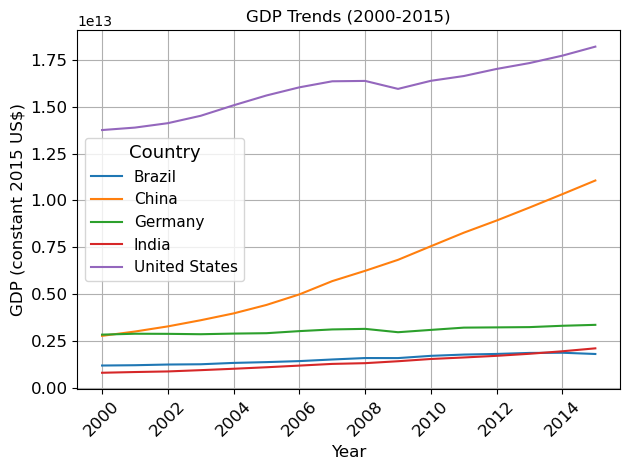

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Excel file containing GDP data
file_path = 'Popular Indicators.xlsx'

# Load the data
data = pd.read_excel(file_path)  # Assumes that the first sheet contains the data

# Filter data for selected countries and indicators
countries = ['United States', 'China', 'Germany', 'India', 'Brazil']
indicators = [
    'GDP (constant 2015 US$)',
    'GDP (current US$)',
    'GDP growth (annual %)',
    'GDP per capita (current US$)',
    'GDP per capita growth (annual %)'
]

filtered_data = data[data['Country Name'].isin(countries) & data['Series Name'].isin(indicators)]

# Trend Analysis for GDP (constant 2015 US$)
gdp_constant = filtered_data[filtered_data['Series Name'] == 'GDP (constant 2015 US$)']
years = [col for col in data.columns if 'YR' in col]
gdp_constant = gdp_constant.pivot(index='Country Name', columns='Series Name', values=years).T
years_readable = [col.split(' ')[0] for col in years]  # Simplify year labels for the x-axis
gdp_constant.index = years_readable

# Create a more readable and cleaner plot
plt.figure(figsize=(10, 6))  # Set a larger figure size for better readability
gdp_constant.plot(title='GDP Trends (2000-2015)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.ylabel('GDP (constant 2015 US$)', fontsize=12)
plt.legend(title='Country', title_fontsize='13', fontsize='11')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.grid(True)
plt.tight_layout()  # Adjust the padding to ensure the fit of all labels 
plt.show()


<Figure size 1000x600 with 0 Axes>

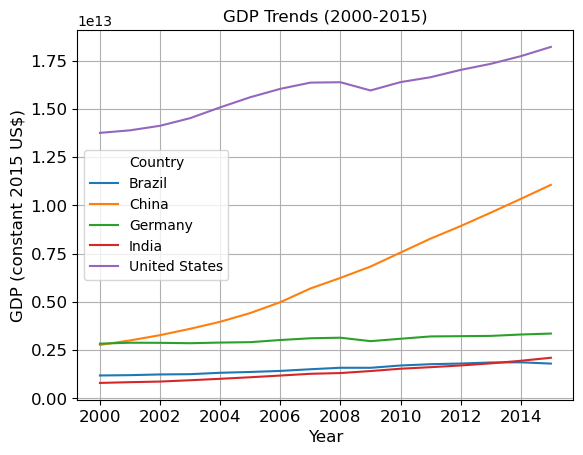

<Figure size 1000x600 with 0 Axes>

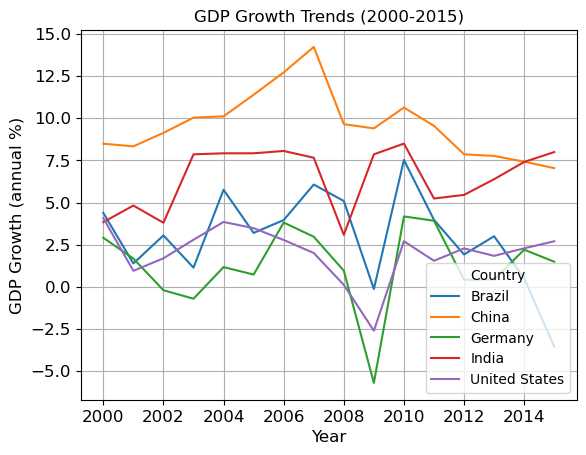

Summary Table for the Latest Year:
Series Name   GDP (constant 2015 US$)     GDP (current US$)  \
Country Name                                                  
Brazil           1802212206904.677734  1802212206904.677734   
China               11061572618594.75     11061572618594.75   
Germany          3357585719351.560547  3357585719351.560547   
India            2103588360066.323486  2103588360066.323486   
United States          18206020741000        18206020741000   

Series Name   GDP growth (annual %) GDP per capita (current US$)  \
Country Name                                                       
Brazil                    -3.545763                  8783.215424   
China                      7.041329                  8016.445595   
Germany                    1.491932                 41103.256436   
India                      7.996254                  1590.174331   
United States               2.70637                 56762.729452   

Series Name   GDP per capita growth (annual %)

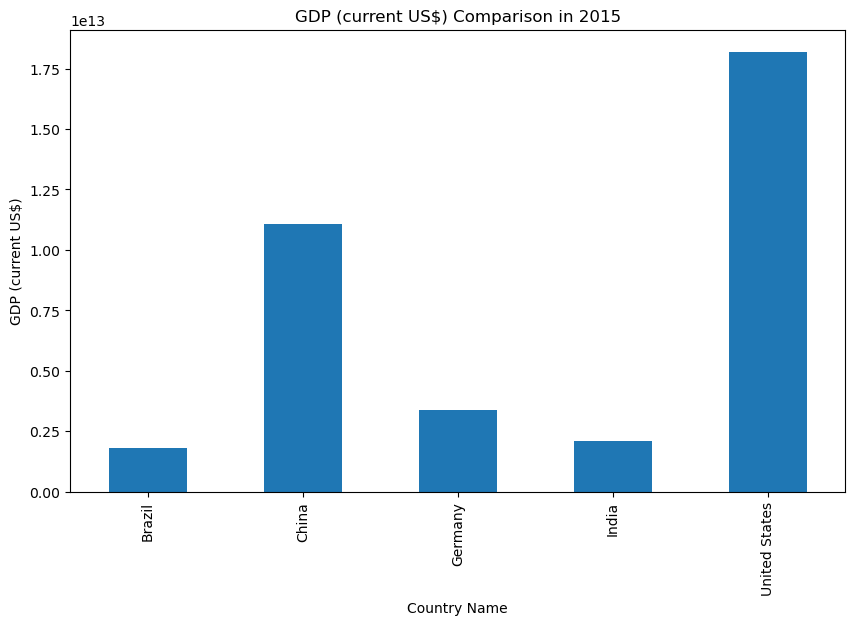

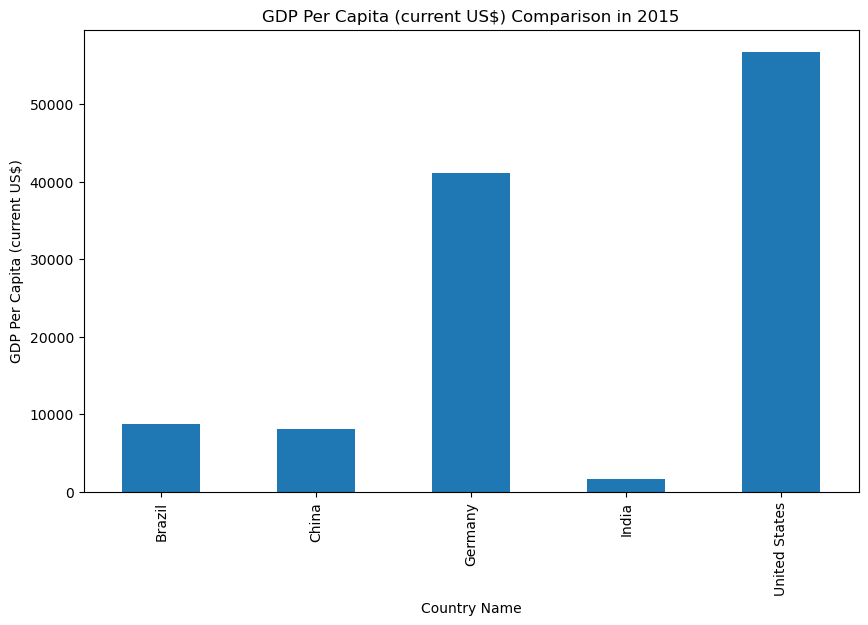

In [3]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Set up the environment and file path for the Excel data
# Excel file containing GDP data
file_path = 'Popular Indicators.xlsx'
data = pd.read_excel(file_path)

# Define the analysis scope
countries = ['United States', 'China', 'Germany', 'India', 'Brazil']
indicators = [
    'GDP (constant 2015 US$)',
    'GDP (current US$)',
    'GDP growth (annual %)',
    'GDP per capita (current US$)',
    'GDP per capita growth (annual %)'
]

# Data Filtering Section
# Filter the dataset for the selected countries and indicators
filtered_data = data[data['Country Name'].isin(countries) & data['Series Name'].isin(indicators)]
years = [col for col in data.columns if 'YR' in col]
years_readable = [yr.split(' ')[0] for yr in years]

# GDP Trends Analysis Section
# Trend analysis for GDP (constant 2015 US$)
gdp_constant = filtered_data[filtered_data['Series Name'] == 'GDP (constant 2015 US$)']
gdp_constant = gdp_constant.pivot(index='Country Name', columns='Series Name', values=years).T
gdp_constant.index = years_readable

# Plot GDP trends
plt.figure(figsize=(10, 6))
gdp_constant.plot(title='GDP Trends (2000-2015)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.ylabel('GDP (constant 2015 US$)', fontsize=12)
plt.legend(title='Country', fontsize=10)
plt.grid(True)
plt.show()

# GDP Growth Trends Analysis Section
# Trend analysis for GDP Growth (annual %)
gdp_growth = filtered_data[filtered_data['Series Name'] == 'GDP growth (annual %)']
gdp_growth = gdp_growth.pivot(index='Country Name', columns='Series Name', values=years).T
gdp_growth.index = years_readable

# Plot GDP growth trends
plt.figure(figsize=(10, 6))
gdp_growth.plot(title='GDP Growth Trends (2000-2015)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.ylabel('GDP Growth (annual %)', fontsize=12)
plt.legend(title='Country', fontsize=10)
plt.grid(True)
plt.show()

# Comparative Analysis Section
# Comparative analysis for the latest year
latest_year = '2015 [YR2015]'
latest_data = filtered_data[filtered_data[latest_year].notnull() & filtered_data['Series Name'].isin(indicators)]
latest_year_table = latest_data.pivot(index='Country Name', columns='Series Name', values=latest_year)

# Display the summary table for the latest year
print("Summary Table for the Latest Year:")
print(latest_year_table)

# Styled DataFrame Section
# Create a styled DataFrame for the latest year's data
styled_table = latest_year_table.style.format({
    'GDP (constant 2015 US$)': '{:,.2f}',
    'GDP (current US$)': '{:,.2f}',
    'GDP growth (annual %)': '{:.2f}%',
    'GDP per capita (current US$)': '{:,.2f}',
    'GDP per capita growth (annual %)': '{:.2f}%'
}).set_caption("Summary Table for the Latest Year").background_gradient(cmap='viridis', axis=0).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('font-size', '16px'),
        ('color', 'black'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]
}])

# Display the styled table
styled_table

# Bar Graphs Section
# GDP Current US$ Comparison for 2015
plt.figure(figsize=(10, 6))
gdp_current_comparison = filtered_data[filtered_data['Series Name'] == 'GDP (current US$)'].set_index('Country Name')[latest_year]
gdp_current_comparison.plot(kind='bar', title='GDP (current US$) Comparison in 2015')
plt.ylabel('GDP (current US$)')
plt.show()

# GDP Per Capita Current US$ Comparison for 2015
plt.figure(figsize=(10, 6))
gdp_per_capita_comparison = filtered_data[filtered_data['Series Name'] == 'GDP per capita (current US$)'].set_index('Country Name')[latest_year]
gdp_per_capita_comparison.plot(kind='bar', title='GDP Per Capita (current US$) Comparison in 2015')
plt.ylabel('GDP Per Capita (current US$)')
plt.show()


# Read and clean data

Import your data, either through an API or manually, and load it. 

## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [2]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


interactive(children=(Output(),), _dom_classes=('widget-interact',))

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

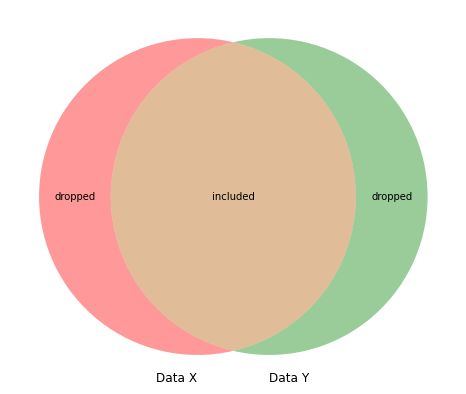

In [3]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.